In [1]:
import os
import glob
import pickle
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from coffea import util
from coffea import processor
from coffea.lookup_tools.dense_lookup import dense_lookup

In [2]:
tagger = "pnet"
flavor = "c"
wp = "tight"
year = "2022EE"

# read and load histograms from pickle files
outputs = glob.glob(f"outputs/{tagger}/{flavor}/{wp}/*.pkl")
histograms = []
for output in outputs:
    with open(output, "rb") as f:
        try:
            histogram = pickle.load(f)
        except Exception as err:
            print(output)
        histograms.append(histogram)
        
# accumulate histograms
tag_efficiency_hist = processor.accumulate(histograms)
tag_efficiency_hist = tag_efficiency_hist["histograms"]
tag_efficiency_hist

Hist(
  StrCategory(['DYto2L_2Jets_0J_1', 'DYto2L_2Jets_0J_10', 'DYto2L_2Jets_0J_11', 'DYto2L_2Jets_0J_12', 'DYto2L_2Jets_0J_13', 'DYto2L_2Jets_0J_14', 'DYto2L_2Jets_0J_15', 'DYto2L_2Jets_0J_16', 'DYto2L_2Jets_0J_17', 'DYto2L_2Jets_0J_18', 'DYto2L_2Jets_0J_19', 'DYto2L_2Jets_0J_2', 'DYto2L_2Jets_0J_20', 'DYto2L_2Jets_0J_21', 'DYto2L_2Jets_0J_22', 'DYto2L_2Jets_0J_23', 'DYto2L_2Jets_0J_24', 'DYto2L_2Jets_0J_25', 'DYto2L_2Jets_0J_26', 'DYto2L_2Jets_0J_27', 'DYto2L_2Jets_0J_28', 'DYto2L_2Jets_0J_29', 'DYto2L_2Jets_0J_3', 'DYto2L_2Jets_0J_30', 'DYto2L_2Jets_0J_4', 'DYto2L_2Jets_0J_5', 'DYto2L_2Jets_0J_6', 'DYto2L_2Jets_0J_7', 'DYto2L_2Jets_0J_8', 'DYto2L_2Jets_0J_9', 'DYto2L_2Jets_1J_1', 'DYto2L_2Jets_1J_10', 'DYto2L_2Jets_1J_11', 'DYto2L_2Jets_1J_12', 'DYto2L_2Jets_1J_13', 'DYto2L_2Jets_1J_14', 'DYto2L_2Jets_1J_15', 'DYto2L_2Jets_1J_16', 'DYto2L_2Jets_1J_17', 'DYto2L_2Jets_1J_18', 'DYto2L_2Jets_1J_19', 'DYto2L_2Jets_1J_2', 'DYto2L_2Jets_1J_20', 'DYto2L_2Jets_1J_21', 'DYto2L_2Jets_1J_22', 

In [3]:
# compute efficiency histogram
numerator = tag_efficiency_hist[{"dataset": sum, "pass_wp": True}]
denominator = tag_efficiency_hist[{"dataset": sum, "pass_wp": sum}]
efficiency = numerator / denominator
efficiency

Hist(
  Variable([20, 30, 50, 70, 100, 140, 200, 300, 600, 1000], name='pt'),
  Regular(10, -2.5, 2.5, name='eta'),
  IntCategory([0, 4, 5], name='flavor'),
  storage=Double()) # Sum: 55.610034578064344 (nan with flow)

In [4]:
# create look-up table from the efficiency map
efflookup = dense_lookup(efficiency.values(), [ax.edges for ax in efficiency.axes]) 
efflookup

3 dimensional histogram with axes:
	1: [  20.   30.   50.   70.  100.  140.  200.  300.  600. 1000.]
	2: [-2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5]
	3: [0. 1. 2. 3.]

In [5]:
# notice that hadron flavours (0, 4, 5) turn into (0, 1, 2). Let's modify them to their original values
efflookup._axes[-1] = np.array([0., 4., 5., 6.])
efflookup

3 dimensional histogram with axes:
	1: [  20.   30.   50.   70.  100.  140.  200.  300.  600. 1000.]
	2: [-2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5]
	3: [0. 4. 5. 6.]

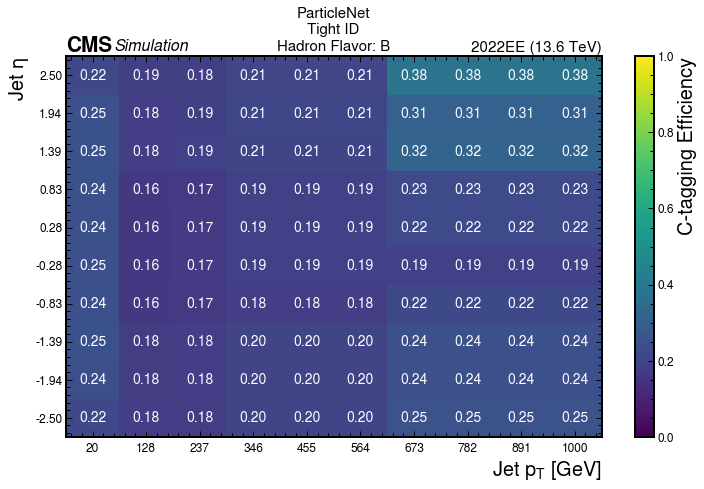

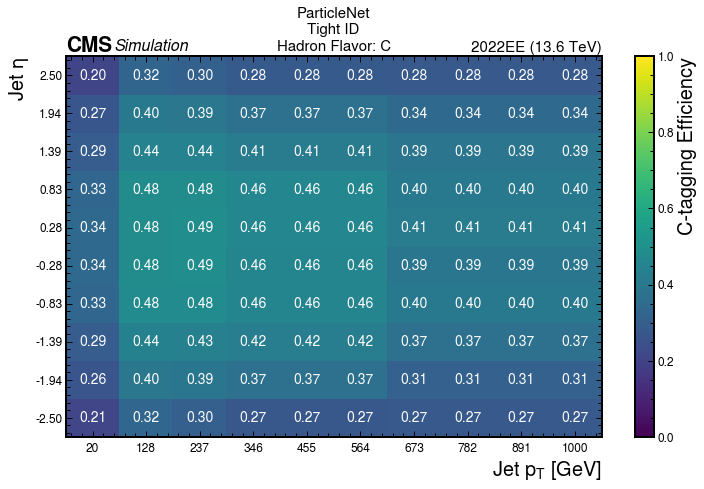

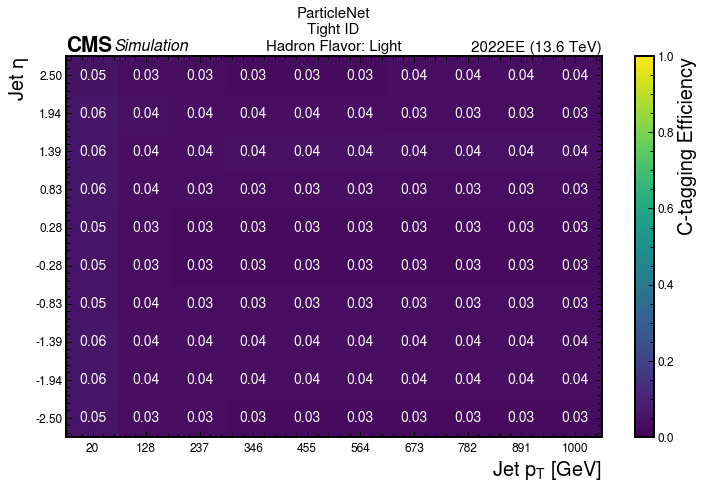

In [8]:
# plot efficiencies for all hadron flavors
hep.style.use(hep.style.CMS)
plt.rcParams.update(
{
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.markersize": 30,
    "legend.fontsize": 10,
    "xtick.minor.width": 1,
    "xtick.minor.size": 4,
    "xtick.major.width": 1,
    "xtick.major.size": 6,
    "ytick.minor.width": 1,
    "ytick.minor.size": 4,
    "ytick.major.width": 1,
    "ytick.major.size": 6,
}
)

bin_x_values = np.array([20, 30, 50, 70, 100, 140, 200, 300, 600, 1000])
bin_y_values = np.linspace(-2.5, 2.5, 10)

pts = np.linspace(20, 1000, 10, dtype="int32") #
etas = np.linspace(-2.5, 2.5, 10)
pt, eta = np.meshgrid(pts, etas)

taggers_map = {
"deepjet": "DeepJet",
"pnet": "ParticleNet",
"part": "Robust Particle Transformer"
}
flavor_tags = {0: "Light", 4: "C", 5: "B"}
for i, flav in enumerate([5, 4, 0]):
    fig, ax = plt.subplots(figsize=(12, 7))
    eff_map = efflookup(pt, eta, flav)
    
    heatmap = ax.pcolor(eff_map, vmin=0, vmax=1)
    for y in range(eff_map.shape[0]):
        for x in range(eff_map.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % eff_map[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color="w",
                     fontsize=14,
                     )
    cbar = fig.colorbar(heatmap)
    cbar.set_label(f'{flavor.upper()}-tagging Efficiency')
    
    ax.set_xlabel('Jet $p_T$ [GeV]')
    ax.set_ylabel('Jet $\eta$')
    ax.set_title(f"{taggers_map[tagger]}\n{wp.title()} ID\nHadron Flavor: {flavor_tags[flav]}", size=15)
    
    ax.set_xticks(np.arange(len(pts))+0.5)  # Centering ticks between heatmap cells
    ax.set_xticklabels(pts)
    ax.set_yticks(np.arange(len(etas))+0.5)  # Centering ticks between heatmap cells
    ax.set_yticklabels([f"{eta_val:.2f}" for eta_val in etas])
    
    hep.cms.lumitext("2022EE (13.6 TeV)", ax=ax)
    hep.cms.text("Simulation", loc=0, ax=ax)

In [7]:
# save look-up table
output_path = f"analysis/data/{flavor}tag_eff_{tagger}_{wp}_{year}.coffea"
util.save(efflookup, output_path)